# Setting up inputs for the gridded DBPM run
**Author**: Denisse Fierro Arcos  
**Date**: 2025-01-10  
  
In this notebook, we will prepare all necessary inputs need to run the gridded version of DBPM. Note that this step needs to be completed only once for each model run.  

## Loading relevant libraries

In [1]:
import os
os.chdir('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/new_workflow/')
import xarray as xr
import json
import pandas as pd
import numpy as np
import useful_functions as uf
from dask.distributed import Client

## Start a cluster for parallelisation

In [ ]:
client = Client(threads_per_worker = 1)

## Defining output folder

In [2]:
base_folder = '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/'
out_folder = os.path.join(base_folder, 'gridded_params')
os.makedirs(out_folder, exist_ok = True)

## Transforming DBPM parameters to Python-friendly format
These parameters are the outputs of the `sizeparam` function for R. They were calculated and stored in the script ([04_calculating_dbpm_fishing_params](new_workflow/04_calculating_dbpm_fishing_params.R)) as a `json` file.

In [3]:
#Loading gridded parameters
gridded_params = json.load(open('gridded_params_testing.json'))

#Transforming them to Python friendly format
gridded_python = uf.gridded_param_python(gridded_params)

### Adding useful entries to gridded parameters
These variables are used multiple times within the `gridded_size_model` script, so they will be added for convenience.

In [80]:
# Size classes
log10_size_bins = np.array(gridded_params['log10_size_bins'])
# Minimum (log10) size class for predators
log10_ind_min_pred_size = log10_size_bins[gridded_python['ind_min_pred_size']]
log10_ind_min_detritivore_size = log10_size_bins[gridded_python['ind_min_detritivore_size']]

#Adding new variables to gridded parameters
gridded_python['log10_ind_min_pred_size'] = log10_ind_min_pred_size
gridded_python['log10_ind_min_detritivore_size'] = log10_ind_min_detritivore_size

### Saving gridded parameters

In [ ]:
out_gridded = os.path.join(out_folder,
                           'dbpm_size_params_fao-58_python.json')
#Save to disk
with open(out_gridded, 'w') as outfile:
    json.dump(gridded_python, outfile)

## Loading gridded input data
Gridded data are needed both as direct input to DBPM and to calculate params, such as habitat preference, pelagic predator and benthic detritivore size spectrum, among other things.

In [6]:
depth = xr.open_zarr(
    os.path.join(base_folder, 'gridded', 
                 'gfdl-mom6-cobalt2_obsclim_deptho_15arcmin_fao-58_fixed.zarr/'))
# depth = depth['deptho'].chunk({'lat': '50MB', 'lon': '50MB'})
depth = depth.sel(lat = slice(-60, None), lon = slice(70, 80))

In [7]:
int_phy_zoo = xr.open_zarr(os.path.join(
    base_folder, 'gridded', 
    'gfdl-mom6-cobalt2_obsclim_intercept_15arcmin_fao-58_monthly_1961_2010.zarr/'))
# int_phy_zoo = int_phy_zoo['intercept'].chunk({'time': '50MB', 'lat': '50MB',
#                                               'lon': '50MB'})
int_phy_zoo = (int_phy_zoo['intercept'].sel(time = '1961').
                sel(lat = slice(-60, None), lon = slice(70, 80)))

In [8]:
slope_phy_zoo_mat = xr.open_zarr(os.path.join(
    base_folder, 'gridded', 
    'gfdl-mom6-cobalt2_obsclim_slope_15arcmin_fao-58_monthly_1961_2010.zarr/'))
# slope_phy_zoo_mat = slope_phy_zoo_mat['slope'].chunk({'time': '50MB', 'lat': '50MB',
#                                                       'lon': '50MB'})
slope_phy_zoo_mat = (slope_phy_zoo_mat['slope'].sel(time = '1961').
                sel(lat = slice(-60, None), lon = slice(70, 80)))

### Creating time variable that contains a timestep for initialisation of DBPM

In [9]:
#Adding new 'time_init' input that includes timestep for initialisation of DBPM
time_init = np.array(
    pd.date_range((int_phy_zoo.indexes['time'].to_datetimeindex().min()-
                   pd.DateOffset(months = 1)),
                  int_phy_zoo.indexes['time'].to_datetimeindex().max(),
                  freq = 'MS'), dtype = 'datetime64[ns]')

/jobfs/132110496.gadi-pbs/ipykernel_1837468/1065116443.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  pd.date_range((int_phy_zoo.indexes['time'].to_datetimeindex().min()-
/jobfs/132110496.gadi-pbs/ipykernel_1837468/1065116443.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  int_phy_zoo.indexes['time'].to_datetimeindex().max(),


## Creating gridded variables needed for DBPM run
We will create data array versions of the gridded inputs.

### DBPM size classes

In [10]:
# Log10 size of individuals found in the model
log10_size_bins_mat = xr.DataArray(data = log10_size_bins,
                                   dims = ['size_class'], 
                                   coords = {'size_class': log10_size_bins})

# size of individuals found in the model
size_bin_vals = 10**log10_size_bins_mat

### Fishing effort

In [11]:
effort = (xr.DataArray(gridded_python['effort'], dims = 'time', 
                       coords = {'time': int_phy_zoo.time}).
          expand_dims({'lat': depth.lat, 'lon': depth.lon}).
          transpose('time', 'lat', 'lon').
          chunk({'time': '50MB', 'lat': '50MB', 'lon': '50MB'}))

### Setting habitat preferences
Predator coupling to benthic prey, which is depth dependent, 0.75 above 500 m, 0.5 between 500 and 1800 m, and 0 below 1800 m. Predator coupling to pelagic prey is equal to `1-(benthic coupling)`.  
  
These values were suggested by Clive Trueman based on stable isotope work, and proportion of biomass. Rockall Trough studies.

In [12]:
pref_benthos = (0.8*np.exp((-1/250*depth))).chunk({'lat': '50MB', 'lon': '50MB'})
pref_pelagic = (1-pref_benthos)

### Initiliasing values for pelagic predators and benthic detritivores

In [13]:
init_pred = (xr.DataArray(data = gridded_python['init_pred'], 
                          dims = ['size_class'], 
                          coords = {'size_class': log10_size_bins}).
             expand_dims({'lat': depth.lat, 'lon': depth.lon}).
             chunk({'lat': '50MB', 'lon': '50MB', 'size_class': '50MB'}))

init_detritivores = (xr.DataArray(data = gridded_python['init_detritivores'], 
                                  dims = ['size_class'], 
                                  coords = {'size_class': log10_size_bins}).
                     expand_dims({'lat': depth.lat, 'lon': depth.lon}).
                     chunk({'lat': '50MB', 'lon': '50MB', 'size_class': '50MB'}))

### Calculating constant growth and mortality

In [15]:
pred_prey_mat = uf.pred_prey_matrix(log10_size_bins)

constant_growth = xr.DataArray(uf.gphi_f(pred_prey_mat, 
                                         gridded_python['log10_pred_prey_ratio'],
                                         gridded_python['log_prey_pref']),
                               dims = ['size_class', 'sc'])

constant_mortality = xr.DataArray(uf.mphi_f(-pred_prey_mat, 
                                            gridded_python['log10_pred_prey_ratio'],
                                            gridded_python['log_prey_pref'],
                                            gridded_python['metabolic_req_pred']),
                                  dims = ['size_class', 'sc'])

### Building metabolic requirements lookup table 
Metabolic requirements are estimated per size class

In [16]:
met_req_log10_size_bins = uf.expax_f(log10_size_bins_mat, 
                                     gridded_python['metabolic_req_pred'])

### Creating a gridded time series of intercept of plankton size spectrum 
The size spectrum was estimated by the `GetPPIntSlope` function using GFDL-MOM6-COBALT2 outputs in script ([01_processing_dbpm_global_inputs](new_workflow/01_processing_dbpm_global_inputs.ipynb)).

In [17]:
ui0 = (10**int_phy_zoo).chunk({'lat': '50MB', 'lon': '50MB', 'time': '50MB'})

### Predator and detritivore biomass, plus detritus
Values are derived from plankton-zooplankton size spectrum, slope and size class.

In [74]:
# Calculating predator biomass
pred_init = ui0*(10**(slope_phy_zoo_mat*log10_size_bins_mat))
# Keep values outside the predator size classes, otherwise change to zero (0)
pred_init = xr.where(pred_init.size_class <= log10_ind_min_pred_size,
                     pred_init, 0)
# Copy first time step predator values as 'initialisation' timestep
pred_init = xr.concat([pred_init.isel(time = 0), pred_init], dim = 'time')
# Update time labels
pred_init['time'] = time_init

# Initialising detritivores
detri_init = xr.zeros_like(pred_init)

# Initialising detritus
detritus = xr.zeros_like(pred_init.isel(size_class = 0).drop_vars('size_class'))
# Assign detritus value to initial timestep
detritus = xr.where(detritus.time == detritus.time.min(), 
                    gridded_python['init_detritus'], detritus)

Setting initial biomass values for predator and detritivore from gridded parameters.

In [75]:
predators = xr.where((pred_init.time == pred_init.time.min()) & 
                      (pred_init.size_class >= log10_ind_min_pred_size),
                     init_pred, pred_init)
detritivores = xr.where((detri_init.time == detri_init.time.min()) & 
                        (detri_init.size_class >= log10_ind_min_detritivore_size),
                        init_detritivores, detri_init)

## Note
If no initial values for `predators` and `detritivores` are included in the gridded parameters, use the following code instead:  
  
```
predators = xr.where((pred_init.time == pred_init.time.min()) &
                       (pred_init.size_class >= log10_ind_min_pred_size) &
                       (pred_init.size_class < log10_size_bins[120]),
                       init_pred, pred_init)

detritivores = xr.where((detri_init.time == detri_init.time.min()) &
                         (detri_init.size_class >= log10_ind_min_detritivore_size) &
                         (detri_init.size_class < log10_size_bins[120]), 
                         init_detritivores, detri_init)
```

### Instrinsic natural mortality 

In [92]:
other_mort_det = gridded_python['natural_mort']*10**(-0.25*log10_size_bins_mat)
other_mort_pred = gridded_python['natural_mort']*10**(-0.25*log10_size_bins_mat)

### Senescence mortality rate 
These values limit large fishes from building up in the system. This is the same function used in Law et al 2008. Using the parameters chosen in the chunk below, it gives similar M2 values to Hall et al. 2006.

In [93]:
senes_mort_det = (gridded_python['const_senescence_mort']*
                  10**(gridded_python['exp_senescence_mort']*
                       (log10_size_bins_mat-gridded_python['size_senescence'])))
senes_mort_pred = (gridded_python['const_senescence_mort']*
                   10**(gridded_python['exp_senescence_mort']*
                        (log10_size_bins_mat-gridded_python['size_senescence'])))

### Fishing mortality
Here `fishing_mort_pred` and `fishing_mort_det` are fixed catchability terms for `predators` and `detritivores`. Fishing mortality is estimated only for individuals within fished sizes (`ind_min_fish_pred` or `ind_min_fish_det`).

In [108]:
fish_mort_pred = xr.zeros_like(predators_init)
# fishing_mort_pred = xr.where((fish_mort_pred.size_class >= log10_size_bins[ind_min_fish_pred]) &
#                              (fish_mort_pred.size_class < fish_mort_pred.size_class.max()) & 
#                              (fish_mort_pred.time == fish_mort_pred.time.min()), 
#                              gridded_params['fish_mort_pred']*effort.isel(time = 0), 
#                              fish_mort_pred)

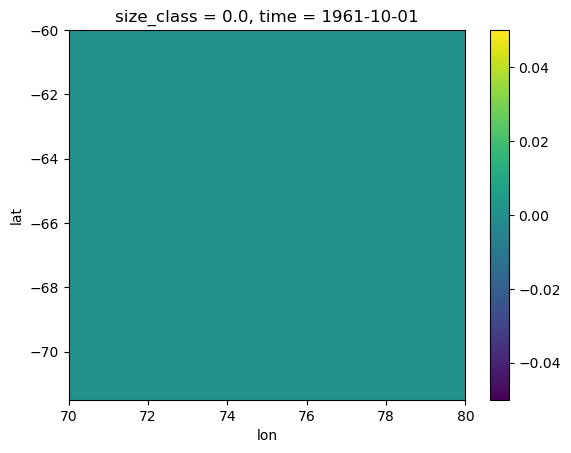

In [113]:
# fish_mort_pred = gridded_python['fish_mort_pred']
fish_mort_pred.where(fish_mort_pred == 0, 
# fish_mort_pred[120,...,10].plot()

In [115]:
gridded_python['fish_mort_pred']

0.60725889235

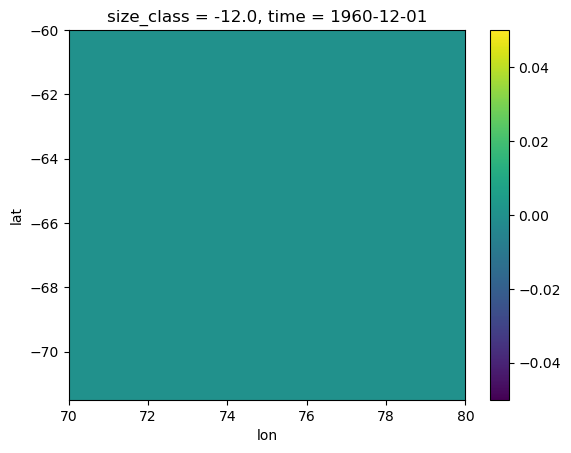

In [125]:
fish_mort_pred[0, ..., 0].plot()

In [132]:
13*181*46*40

4329520

In [135]:
predators

<xarray.DataArray (time: 13, size_class: 181, lat: 46, lon: 40)> Size: 35MB
dask.array<where, shape=(13, 181, 46, 40), dtype=float64, chunksize=(12, 181, 34, 40), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 104B 1960-12-01 1961-01-01 ... 1961-12-01
  * size_class  (size_class) float64 1kB -12.0 -11.9 -11.8 -11.7 ... 5.8 5.9 6.0
  * lat         (lat) float64 368B -60.12 -60.38 -60.62 ... -70.88 -71.12 -71.38
  * lon         (lon) float64 320B 70.12 70.38 70.62 70.88 ... 79.38 79.62 79.88

In [165]:
fish_mort_pred = xr.DataArray(
    np.repeat(gridded_python['fish_mort_pred'], 
              np.prod(predators.shape)).reshape(predators.shape),
    dims = ['time', 'size_class', 'lat', 'lon'],
    coords = {'time': predators.time,
              'size_class': predators.size_class, 
              'lat': predators.lat, 'lon': predators.lon})

fish_mort_pred = xr.where((fish_mort_pred.size_class >= 
                           log10_size_bins[gridded_python['ind_min_fish_pred']]) &
                          (fish_mort_pred.size_class < 
                           fish_mort_pred.size_class.max()),
                          fish_mort_pred, 0)

fishing_mort_pred = xr.where(fish_mort_pred.time == fish_mort_pred.time.min(),
                             fish_mort_pred*effort.isel(time = 0), 0)
# fish_mort_pred = 
# gridded_python['fish_mort_pred']
# test = fish_mort_pred.where(fish_mort_pred == 0, gridded_python['fish_mort_pred'])
# test.sum(('lat', 'lon')).plot()

In [167]:
effort.time

<xarray.DataArray 'time' (time: 12)> Size: 96B
array([cftime.Datetime360Day(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1961, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1961, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1961, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1961, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1961, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1961, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1961, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1961, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1961, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1961, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1961, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 96B 1961-01-01 00:00:00 ... 1961-12-01 00:00:00
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time

In [101]:
print(log10_size_bins[gridded_python['ind_min_fish_pred']],
      gridded_python['ind_min_fish_pred'])

0.1 121


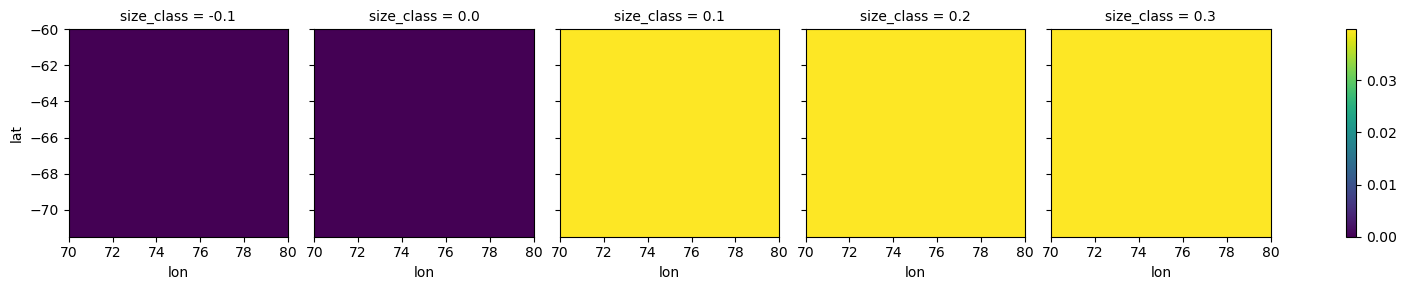

In [166]:
fishing_mort_pred[0, 119:124, ...].plot(col = 'size_class')

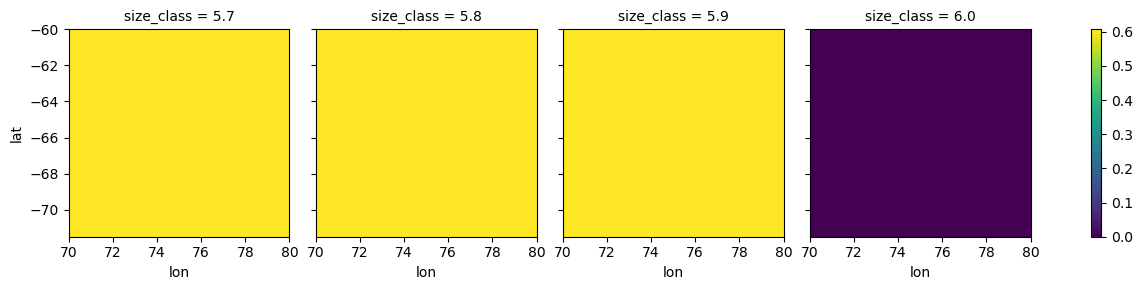

In [152]:
fish_mort_pred[-4:, 0, ...].plot(col = 'size_class')

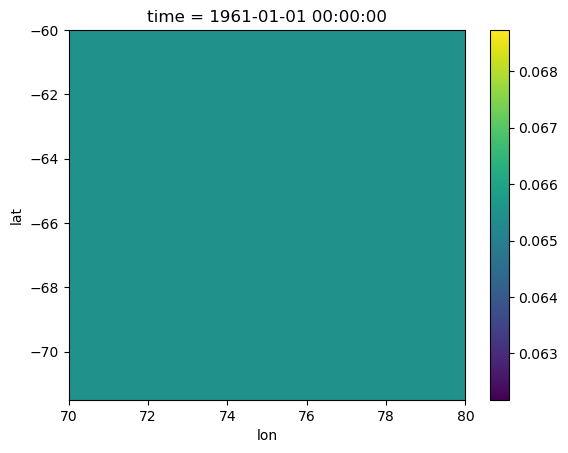

In [154]:
effort.isel(time = 0).plot()

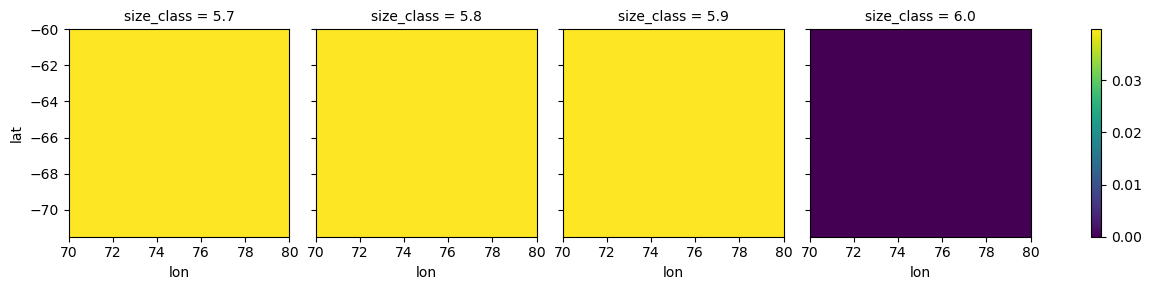

In [161]:
# test = xr.where(fish_mort_pred.time == fish_mort_pred.time.min(),
                          # fish_mort_pred*effort.isel(time = 0), fish_mort_pred)
test[0, -4:, ...].plot(col = 'size_class')